## Part 1 ##

In [68]:
import numpy as np
from sklearn.linear_model import LassoCV as LassoCV
from sklearn.linear_model import Lasso as Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse
import matplotlib.pyplot as plt
import time

In [60]:
## Note: got this func from Felix ##
def simulate_data(n, p, rng, *, sparsity=0.95, SNR=2.0, beta_scale=5.0):
    """Simulate data for Project 3, Part 1.

    Parameters
    ----------
    n : int
        Number of samples
    p : int
        Number of features
    rng : numpy.random.Generator
        Random number generator (e.g. from `numpy.random.default_rng`)
    sparsity : float in (0, 1)
        Percentage of zero elements in simulated regression coefficients
    SNR : positive float
        Signal-to-noise ratio (see explanation above)
    beta_scale : float
        Scaling for the coefficient to make sure they are large

    Returns
    -------
    X : `n x p` numpy.array
        Matrix of features
    y : `n` numpy.array
        Vector of responses
    beta : `p` numpy.array
        Vector of regression coefficients
    """
    
    X = rng.standard_normal(size=(n, p))
    q = int(np.ceil((1.0 - sparsity) * p))
    beta = np.zeros((p,), dtype=float)
    beta[:q] = beta_scale * rng.standard_normal(size=(q,))
    
    sigma = np.sqrt(np.sum(np.square(X @ beta)) / (n - 1)) / SNR

    y = X @ beta + sigma * rng.standard_normal(size=(n,))

    # Shuffle columns so that non-zero features appear
    # not simply in the first (1 - sparsity) * p columns
    idx_col = rng.permutation(p)
    
    return X[:, idx_col], y, beta[idx_col]
    

In [96]:
def calc(n, sparsity, k, X_train, X_test, y_train, y_test):
    lasso = LassoCV().fit(X_train,y_train)
    alpha_min = lasso.alpha_
   
    ## Note: got this paragraph from Felix ##
    cv_mean = np.mean(lasso.mse_path_, axis=1)
    cv_std = np.std(lasso.mse_path_, axis=1)
    idx_min_mean = np.argmin(cv_mean)
    idx_alpha = np.where(
        (cv_mean <= cv_mean[idx_min_mean] + cv_std[idx_min_mean]) &
        (cv_mean >= cv_mean[idx_min_mean])
    )[0][0]
    alpha_1se = lasso.alphas_[idx_alpha]

    mse_min = cv_mean[idx_min_mean]
    MSE_train_min[k,0] = mse_min; MSE_train_min[k,1] = mse_min/n; MSE_train_min[k,2] = mse_min/sparsity 
    lambda_mins[k] = alpha_min

    mse_1se = cv_mean[idx_alpha]
    MSE_train_1se[k,0] =  mse_1se; MSE_train_1se[k,1] = mse_1se/n; MSE_train_1se[k,2] = mse_1se/sparsity 
    lambda_1ses[k] = alpha_1se

    
    
    pred_min = lasso.predict(X_test)
    lasso_1se = Lasso(alpha = alpha_1se).fit(X_train, y_train)
    pred_1se = lasso_1se.predict(X_test)
    
    mse_min = mse(pred_min, y_test)
    MSE_test_min[k,0] =  mse_min; MSE_test_min[k,1] = mse_min/n; MSE_test_min[k,2] = mse_min/sparsity 
    
    mse_1se = mse(pred_1se,y_test)
    MSE_test_1se[k,0] =  mse_1se; MSE_test_1se[k,1] = mse_1se/n; MSE_test_1se[k,2] = mse_1se/sparsity
    
    
    beta_est_min = lasso.coef_
    beta_est_1se = lasso_1se.coef_
    
    return beta_est_min, beta_est_1se

In [114]:
def eval_feature_selection(beta_est_min, beta_est_1se, beta):
    
    sel_feat_est_min = np.zeros(len(beta_est_min))
    sel_feat_est_min[np.argwhere(beta_est_min != 0)] = 1
    
    
    sel_feat_est_1se = np.zeros(len(beta_est_1se))
    sel_feat_est_1se[np.argwhere(beta_est_1se != 0)] = 1
    
    sel_feat_true = np.zeros(len(beta))
    sel_feat_true[np.argwhere(beta != 0)] = 1
    
    sum_min = sel_feat_est_min + sel_feat_true
    sum_1se = sel_feat_est_1se + sel_feat_true
    
    sens_min = len(np.argwhere(sum_min == 2))/len(np.argwhere(sel_feat_est_min == 1))
    sens_1se = len(np.argwhere(sum_1se == 2))/len(np.argwhere(sel_feat_est_1se == 1))
    
    spec_min = len(np.argwhere(sum_min == 0))/len(np.argwhere(sel_feat_est_min == 0))
    spec_1se = len(np.argwhere(sum_1se == 0))/len(np.argwhere(sel_feat_est_1se == 0))
    
    return sens_min, sens_1se, spec_min, spec_1se
    
    
    
    

In [118]:
p = 500
n_vector = [100, 300, 400]
n_test = 500
sparsity_vector = [0.75, 0.9, 0.95, 0.99]
SNR = 5.0
beta_scale = 5.0
nr_runs = 5
rng = np.random.default_rng()

nr_datasets = int(len(n_vector)*len(sparsity_vector)*nr_runs)

lambda_mins = np.zeros(nr_datasets)
lambda_1ses = np.zeros(nr_datasets)

MSE_train_min = np.zeros((nr_datasets,3))
MSE_test_min = np.zeros((nr_datasets,3))
MSE_train_1se = np.zeros((nr_datasets,3))
MSE_test_1se = np.zeros((nr_datasets,3))

sens_min = np.zeros((nr_datasets,3))
sens_1se = np.zeros((nr_datasets,3))
spec_min = np.zeros((nr_datasets,3))
spec_1se = np.zeros((nr_datasets,3))


k = 0
illustrate = True
verbose = True

if(verbose):
    print(f"number of datasets to generate: {nr_datasets}")
    t0 = time.time()
for n in n_vector:
    for sparsity in sparsity_vector:
        for i in range(nr_runs):
            X, y, beta = simulate_data(n + n_test, p, rng, sparsity = sparsity, SNR = SNR, beta_scale = SNR)
            X_train, X_test, y_train, y_test = train_test_split(X,y,
                                                                test_size = round(n_test/(n_test + n)),
                                                                random_state = 0)
            
            
            beta_est_min, beta_est_1se = calc(n, sparsity, k, X_train, X_test, y_train, y_test) 
            
            
            
            sens_m, sens_1, spec_m, spec_1 = eval_feature_selection(beta_est_min, beta_est_1se, beta)
            sens_min[k,0] = sens_m; sens_min[k,1] = sens_m/n; sens_min[k,2] = sens_m/sparsity
            sens_1se[k,0] = sens_1; sens_1se[k,1] = sens_1/n; sens_1se[k,2] = sens_1/sparsity
            spec_min[k,0] = spec_m; spec_min[k,1] = spec_m/n; spec_min[k,2] = spec_m/sparsity
            spec_1se[k,0] = spec_1; spec_1se[k,1] = spec_1/n; spec_1se[k,2] = spec_1/sparsity
            
            if(verbose):
                t1 = time.time()
                print(f"k = {k},  time ellapsed: {t1-t0} seconds")
                
            k += 1


if(verbose):
    print(f"Total number of datasets generated: {k}")
    t2 = time.time()
    print(f"Total time ellapsed: {t2-t0} seconds")

number of datasets to generate: 60
k = 0,  time ellapsed: 14.725894212722778 seconds
k = 1,  time ellapsed: 28.608511924743652 seconds
k = 2,  time ellapsed: 39.9694766998291 seconds
k = 3,  time ellapsed: 53.812936305999756 seconds
k = 4,  time ellapsed: 65.33382272720337 seconds
k = 5,  time ellapsed: 73.44012689590454 seconds
k = 6,  time ellapsed: 82.4137659072876 seconds
k = 7,  time ellapsed: 91.57868814468384 seconds
k = 8,  time ellapsed: 99.39469146728516 seconds
k = 9,  time ellapsed: 107.05669951438904 seconds
k = 10,  time ellapsed: 114.21530985832214 seconds
k = 11,  time ellapsed: 120.79388761520386 seconds
k = 12,  time ellapsed: 127.9128532409668 seconds
k = 13,  time ellapsed: 134.06975317001343 seconds
k = 14,  time ellapsed: 140.36384773254395 seconds
k = 15,  time ellapsed: 144.60264945030212 seconds
k = 16,  time ellapsed: 149.17038559913635 seconds
k = 17,  time ellapsed: 154.0443878173828 seconds
k = 18,  time ellapsed: 157.99564576148987 seconds
k = 19,  time el

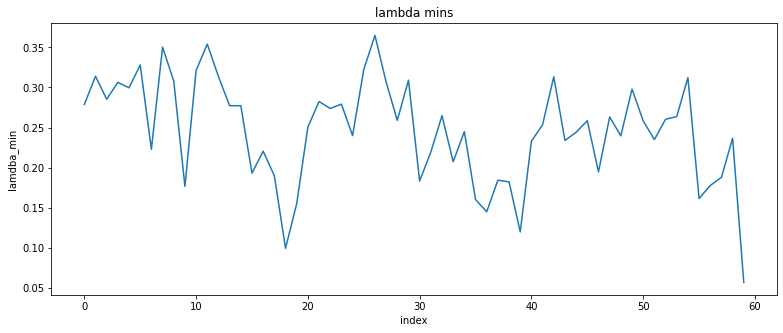

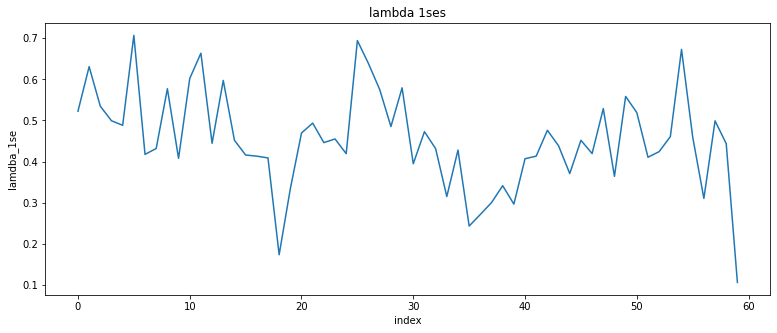

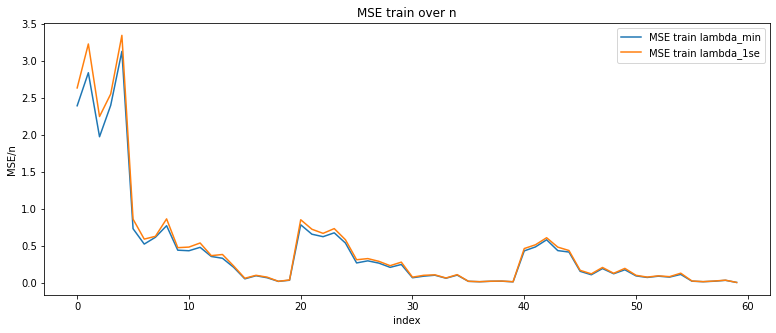

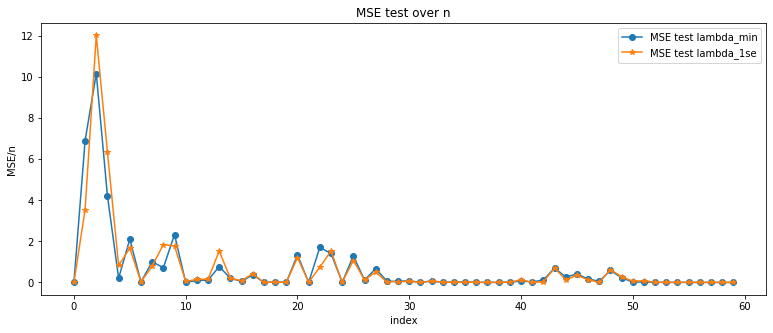

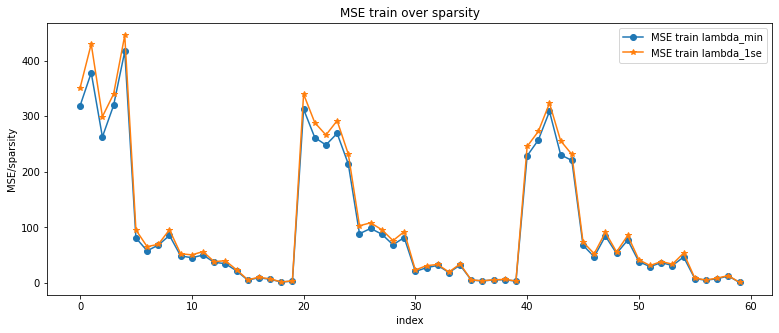

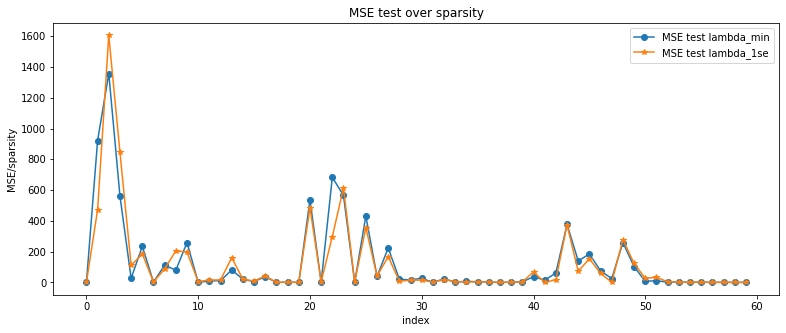

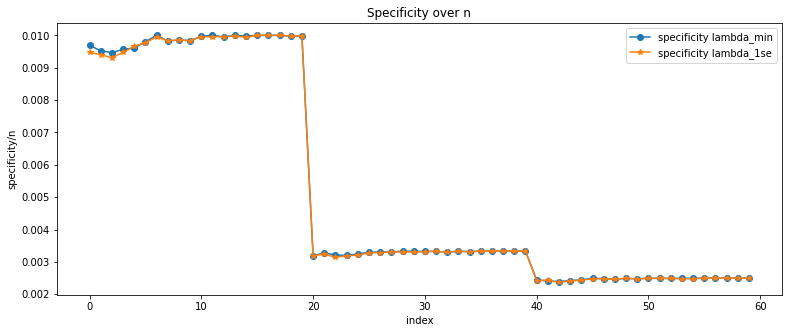

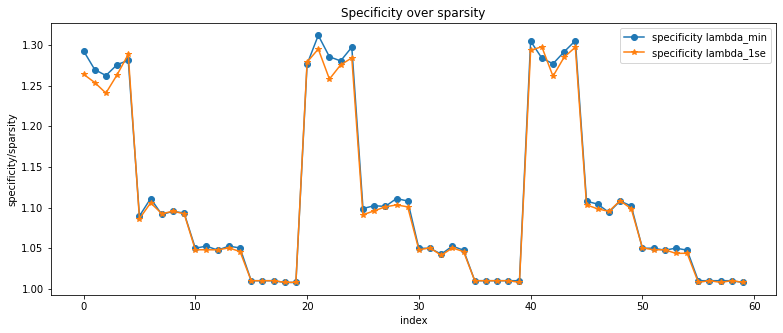

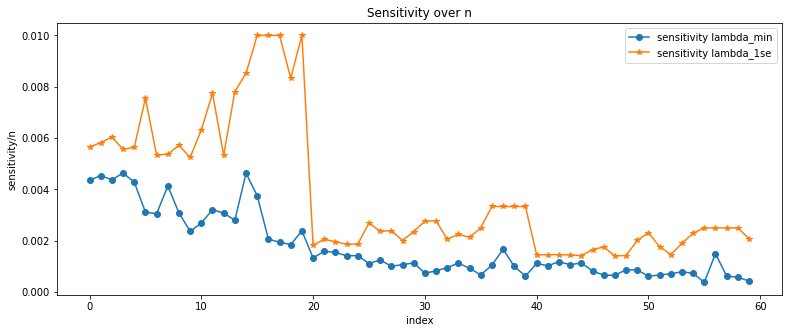

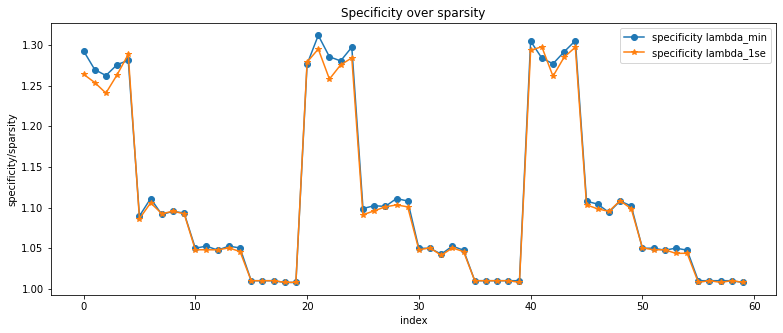

In [119]:

if(illustrate):
    plt.plot(lambda_mins)
    plt.title("lambda mins")
    plt.xlabel("index")
    plt.ylabel("lamdba_min")
    plt.show()
    
    plt.plot(lambda_1ses)
    plt.title("lambda 1ses")
    plt.xlabel("index")
    plt.ylabel("lamdba_1se")
    plt.show()
    
    
    
    plt.plot(MSE_train_min[:,1], label = 'MSE train lambda_min')
    plt.plot(MSE_train_1se[:,1], label = 'MSE train lambda_1se')
    plt.title("MSE train over n")
    plt.xlabel("index")
    plt.ylabel("MSE/n")
    plt.legend()
    plt.show()
    
    plt.plot(MSE_test_min[:,1],'-o', label = 'MSE test lambda_min')
    plt.plot(MSE_test_1se[:,1],'-*', label = 'MSE test lambda_1se')
    plt.title("MSE test over n")
    plt.xlabel("index")
    plt.ylabel("MSE/n")
    plt.legend()
    plt.show()

    
    
    plt.plot(MSE_train_min[:,2],'-o', label = 'MSE train lambda_min')
    plt.plot(MSE_train_1se[:,2],'-*', label = 'MSE train lambda_1se')
    plt.title("MSE train over sparsity")
    plt.xlabel("index")
    plt.ylabel("MSE/sparsity")
    plt.legend()
    plt.show()
    
    plt.plot(MSE_test_min[:,2],'-o', label = 'MSE test lambda_min')
    plt.plot(MSE_test_1se[:,2],'-*', label = 'MSE test lambda_1se')
    plt.title("MSE test over sparsity")
    plt.xlabel("index")
    plt.ylabel("MSE/sparsity")
    plt.legend()
    plt.show()
    
    
    
    plt.plot(spec_min[:,1],'-o', label = 'specificity lambda_min')
    plt.plot(spec_1se[:,1],'-*', label = 'specificity lambda_1se')
    plt.title("Specificity over n")
    plt.xlabel("index")
    plt.ylabel("specificity/n")
    plt.legend()
    plt.show()
    
    plt.plot(spec_min[:,2],'-o', label = 'specificity lambda_min')
    plt.plot(spec_1se[:,2],'-*', label = 'specificity lambda_1se')
    plt.title("Specificity over sparsity")
    plt.xlabel("index")
    plt.ylabel("specificity/sparsity")
    plt.legend()
    plt.show()
    
    
    plt.plot(sens_min[:,1],'-o', label = 'sensitivity lambda_min')
    plt.plot(sens_1se[:,1],'-*', label = 'sensitivity lambda_1se')
    plt.title("Sensitivity over n")
    plt.xlabel("index")
    plt.ylabel("sensitivity/n")
    plt.legend()
    plt.show()
    
    plt.plot(spec_min[:,2],'-o', label = 'specificity lambda_min')
    plt.plot(spec_1se[:,2],'-*', label = 'specificity lambda_1se')
    plt.title("Specificity over sparsity")
    plt.xlabel("index")
    plt.ylabel("specificity/sparsity")
    plt.legend()
    plt.show()

